In [2]:
!pip install numpy opencv-python scikit-learn matplotlib torch torchvision

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import os
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torchvision import transforms

# Define data transformations
data_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Convert the NumPy array to PIL Image
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # For grayscale, adjust as needed
])

# Load dataset
def load_dataset(dataset_path):
    images = []
    labels = []
    for label, folder in [("male", "MaleFaces"), ("female", "FemaleFaces")]:
        label_dir = os.path.join(dataset_path, folder)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))

            # Keep the original NumPy array for feature extraction
            images.append(img)
            labels.append(0 if label == "male" else 1)

    images = np.array(images)  # Convert list of images to NumPy array
    return images, torch.tensor(labels)  # Return NumPy array for images and tensor for labels

In [4]:
# Feature Extraction using Watershed
def extract_features(images):
    features = []
    for img in images:
        # Apply the Watershed algorithm
        ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        sure_bg = cv2.dilate(thresh, None, iterations=3)
        dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        ret, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0
        markers = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers)
        features.append(np.ravel(markers))  # Flatten the feature map
    return np.array(features)

In [5]:
# Define the ANN model
class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)  # Binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [6]:
# Train the model
def train_model(model, criterion, optimizer, X_train, y_train, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")  # Print the epoch and loss
    return losses

In [7]:
# Main script
dataset_path = "./MaleandFemalefacedataset"
images, labels = load_dataset(dataset_path)

# Feature extraction
images = extract_features(images)

# Preprocess data
images = images.reshape(images.shape[0], -1).astype(np.float32) / 255.0  # Flatten and normalize
labels = labels.numpy().astype(np.float32).reshape(-1, 1)  # Reshape for PyTorch

# Convert to PyTorch tensors
images_tensor = torch.from_numpy(images)
labels_tensor = torch.from_numpy(labels)

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True)
accuracies = []

Epoch [20/200], Loss: 0.6388
Epoch [40/200], Loss: 0.5873
Epoch [60/200], Loss: 0.5302
Epoch [80/200], Loss: 0.4821
Epoch [100/200], Loss: 0.4388
Epoch [120/200], Loss: 0.3989
Epoch [140/200], Loss: 0.3663
Epoch [160/200], Loss: 0.3344
Epoch [180/200], Loss: 0.3064
Epoch [200/200], Loss: 0.2810


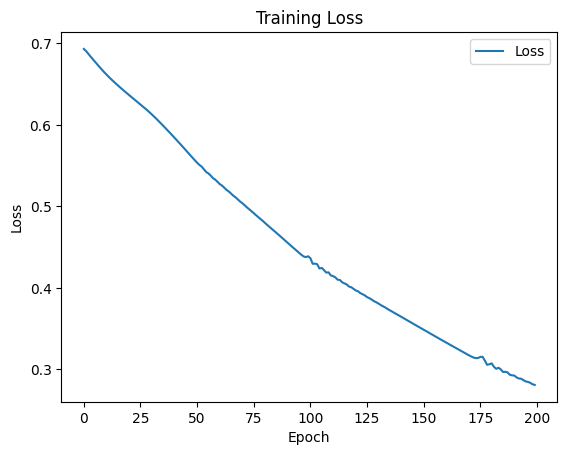

Accuracy: 85.79%
Epoch [20/200], Loss: 0.6459
Epoch [40/200], Loss: 0.6022
Epoch [60/200], Loss: 0.5466
Epoch [80/200], Loss: 0.5006
Epoch [100/200], Loss: 0.4539
Epoch [120/200], Loss: 0.4103
Epoch [140/200], Loss: 0.3706
Epoch [160/200], Loss: 0.3354
Epoch [180/200], Loss: 0.3044
Epoch [200/200], Loss: 0.2771


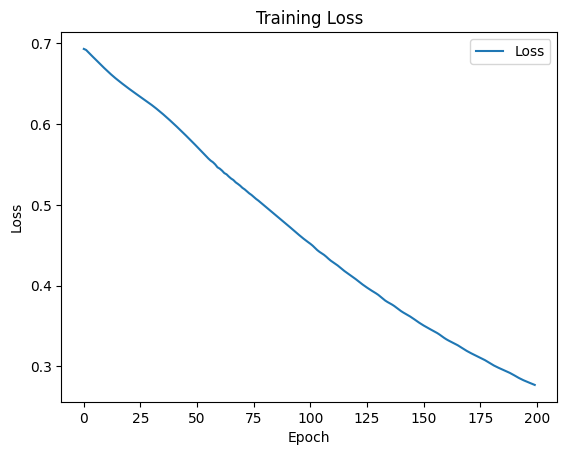

Accuracy: 90.77%
Epoch [20/200], Loss: 0.6456
Epoch [40/200], Loss: 0.6005
Epoch [60/200], Loss: 0.5413
Epoch [80/200], Loss: 0.4924
Epoch [100/200], Loss: 0.4455
Epoch [120/200], Loss: 0.4031
Epoch [140/200], Loss: 0.3650
Epoch [160/200], Loss: 0.3318
Epoch [180/200], Loss: 0.3060
Epoch [200/200], Loss: 0.2816


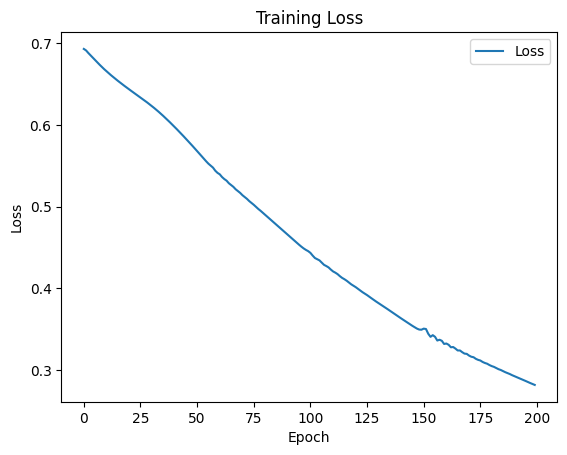

Accuracy: 86.72%
Epoch [20/200], Loss: 0.6564
Epoch [40/200], Loss: 0.6210
Epoch [60/200], Loss: 0.5765
Epoch [80/200], Loss: 0.5266
Epoch [100/200], Loss: 0.4841
Epoch [120/200], Loss: 0.4420
Epoch [140/200], Loss: 0.4036
Epoch [160/200], Loss: 0.3689
Epoch [180/200], Loss: 0.3377
Epoch [200/200], Loss: 0.3097


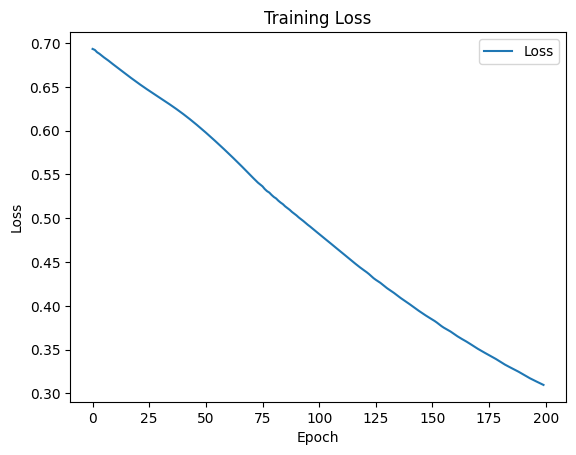

Accuracy: 89.29%
Epoch [20/200], Loss: 0.6460
Epoch [40/200], Loss: 0.6052
Epoch [60/200], Loss: 0.5497
Epoch [80/200], Loss: 0.4981
Epoch [100/200], Loss: 0.4495
Epoch [120/200], Loss: 0.4076
Epoch [140/200], Loss: 0.3684
Epoch [160/200], Loss: 0.3363
Epoch [180/200], Loss: 0.3084
Epoch [200/200], Loss: 0.2825


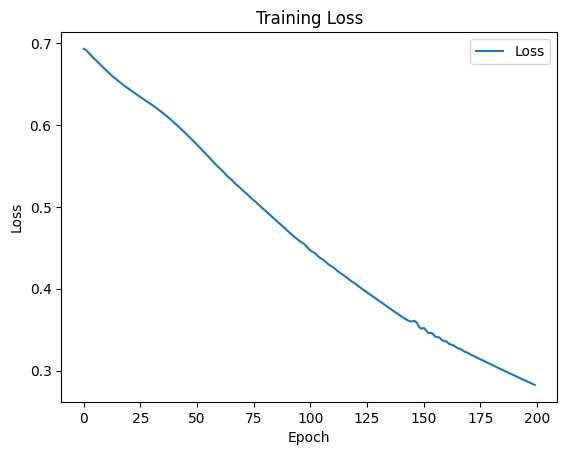

Accuracy: 87.44%
Average Accuracy: 88.00%


In [8]:
for train_index, test_index in kf.split(images_tensor):
    X_train, X_test = images_tensor[train_index], images_tensor[test_index]
    y_train, y_test = labels_tensor[train_index], labels_tensor[test_index]
    
    # Create the model, define the criterion and optimizer
    # model = SimpleANN(input_size=X_train.shape[1], hidden_size=128).to('cuda')  # Move model to GPU if available
    model = SimpleANN(input_size=X_train.shape[1], hidden_size=128)  # Move model to GPU if available
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    # losses = train_model(model, criterion, optimizer, X_train.to('cuda'), y_train.to('cuda'), epochs=100)
    losses = train_model(model, criterion, optimizer, X_train, y_train, epochs=200)

    # Plot loss function
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

    # Test model
    model.eval()
    with torch.no_grad():
        # y_pred = model(X_test.to('cuda'))
        y_pred = model(X_test)
        y_pred = (y_pred.cpu().numpy() > 0.5).astype(int)

    accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

print(f"Average Accuracy: {np.mean(accuracies) * 100:.2f}%")

In [9]:
# print("CUDA Available:", torch.cuda.is_available())
# print("CUDA Device Count:", torch.cuda.device_count())
# print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

# Save the model
torch.save(model.state_dict(), 'model.pth')

In [13]:
# Preprocess a single image
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))  # Resize to match the input size
    img = img / 255.0  # Normalize the image
    
    # Display the image
    plt.imshow(img, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Hide axes
    plt.title(img_path)
    plt.show()
    
    img = img.reshape(1, -1).astype(np.float32)  # Reshape the image to fit the model input (1, 16384)
    return img

# Predict the gender of a single image
def predict_gender(model, img_path):
    img = preprocess_image(img_path)

    # img_tensor = torch.from_numpy(img).to('cuda')  # Move to GPU if available
    img_tensor = torch.from_numpy(img)  # Move to GPU if available
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensor)
        print(f"Prediction: {prediction.item():.4f}")
        gender = 'Male' if prediction < 0.5 else 'Female'

    return gender

In [22]:
print(model)

SimpleANN(
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [17]:
%pip install tensorflow

  Using cached tensorflow-2.17.0-cp312-cp312-win_amd64.whl.metadata (3.2 kB)
  Using cached tensorflow_intel-2.17.0-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.12.1-cp312-cp312-win_amd64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-4.25.5-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.16.0-cp312-cp312-win_amd64.whl.metadata (

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def load_image(img_path, target_size=(224, 224)):
    # Load the image from the path
    img = image.load_img(img_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    # Normalize the image data to [0, 1]
    img_array /= 255.0
    # Expand dimensions to match the model's expected input shape
    img_array = tf.expand_dims(img_array, axis=0)
    return img_array

def predict_gender(model, img_path):
    print(f"Loading image from {img_path}")
    img = load_image(img_path)
    print(f"Image loaded and preprocessed: {img.shape}")
    
    prediction = model.predict(img)
    print(f"Raw model prediction: {prediction}")
    
    predicted_gender = 'female' if prediction[0] > 0.5 else 'male'
    print(f"Predicted gender: {predicted_gender}")
    
    return predicted_gender

# Example usage: predict gender of a new image
img_paths = ['./image.jpg', './image2.jpg', './image3.jpg', './image4.jpg']
for img_path in img_paths:
    predicted_gender = predict_gender(model, img_path)
    print(f'Predicted Gender for {img_path}: {predicted_gender}')

Loading image from ./image.jpg


ValueError: object __array__ method not producing an array

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os

def load_image(img_path, target_size=(224, 224)):
    if not os.path.exists(img_path):
        print(f"Image path does not exist: {img_path}")
        return None
    
    try:
        # Load the image from the path
        img = image.load_img(img_path, target_size=target_size)
        print(f"Image loaded: {img}")
        
        # Convert the image to a numpy array
        img_array = image.img_to_array(img)
        print(f"Image converted to array: {img_array.shape}")
        
        # Normalize the image data to [0, 1]
        img_array /= 255.0
        print(f"Image normalized: {np.min(img_array)}, {np.max(img_array)}")
        
        # Expand dimensions to match the model's expected input shape
        img_array = np.expand_dims(img_array, axis=0)
        print(f"Image array expanded: {img_array.shape}")
        
        return img_array
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

def predict_gender(model, img_path, threshold=0.5):
    print(f"Loading image from {img_path}")
    img = load_image(img_path)
    if img is None:
        print(f"Skipping prediction for {img_path} due to loading error.")
        return None
    
    print(f"Image loaded and preprocessed: {img.shape}")
    
    prediction = model.predict(img)
    print(f"Raw model prediction: {prediction}")
    
    predicted_gender = 'female' if prediction[0] > threshold else 'male'
    print(f"Predicted gender with threshold {threshold}: {predicted_gender}")
    
    return predicted_gender

# Example usage: predict gender of a new image with a custom threshold
img_paths = ['./image.jpg', './image2.jpg', './image3.jpg', './image4.jpg']
custom_threshold = 0.6  # Adjust the threshold value here
for img_path in img_paths:
    predicted_gender = predict_gender(model, img_path, threshold=custom_threshold)
    if predicted_gender is not None:
        print(f'Predicted Gender for {img_path} with threshold {custom_threshold}: {predicted_gender}')

Loading image from ./image.jpg
Image loaded: <PIL.Image.Image image mode=RGB size=224x224 at 0x19B2D65E330>
Image converted to array: (224, 224, 3)
Image normalized: 0.0, 1.0
Image array expanded: (1, 224, 224, 3)
Image loaded and preprocessed: (1, 224, 224, 3)


AttributeError: 'SimpleANN' object has no attribute 'predict'